In [1]:
# Imports:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
from scipy import stats
import random as random

In [2]:
#set seed for reproducibility
random_state = 42
np.random.seed(random_state)

In [3]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_dataset_dict.pickle', 'rb') as f:
    canada_data_dict = pickle.load(f)

In [4]:
canada_data = pd.read_csv(r'/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/resources/canada_cpi_dataset_linear_regression_weights.csv')

In [5]:
canada_data.head()

,Unnamed: 0,Date,Category,Category_id,Price,Weight,Indent,Parent,Parent_ID
0,64800,2013-01-15,All-items,2,121.3,1.0,0.0,NaN,NaN
1,65100,2013-02-15,All-items,2,122.7,1.0,0.0,NaN,NaN
2,65400,2013-03-15,All-items,2,122.9,1.0,0.0,NaN,NaN
3,65700,2013-04-15,All-items,2,122.7,1.0,0.0,NaN,NaN
4,66000,2013-05-15,All-items,2,123.0,1.0,0.0,NaN,NaN


In [6]:
canada_data.groupby('Indent').Price.describe(percentiles = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]).round(2)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Indent,,,,,,,,,,,,
0.0,122.0,133.60,8.64,121.3,123.00,123.38,126.95,132.1,137.20,146.65,152.89,154.5
1.0,2074.0,134.36,19.34,87.9,96.60,115.53,123.50,132.2,144.30,158.07,170.04,242.5
2.0,2562.0,133.95,32.23,73.7,85.51,94.31,116.30,134.4,150.38,167.30,181.99,292.6
3.0,7442.0,138.14,44.47,41.1,77.60,90.90,106.10,135.2,160.20,189.30,223.10,477.0
4.0,10736.0,128.81,37.07,14.5,72.55,85.50,108.30,131.2,151.00,171.10,186.60,299.4
5.0,9760.0,130.14,30.08,37.7,85.90,90.00,103.30,132.3,149.10,168.40,181.00,285.0
6.0,3050.0,107.39,13.71,82.6,92.40,94.50,99.30,102.8,113.10,124.50,134.10,171.4


In [7]:
canada_data.groupby('Indent').Category_id.nunique().reset_index()

,Indent,Category_id
0,0.0,1
1,1.0,17
2,2.0,21
3,3.0,61
4,4.0,88
5,5.0,80
6,6.0,25


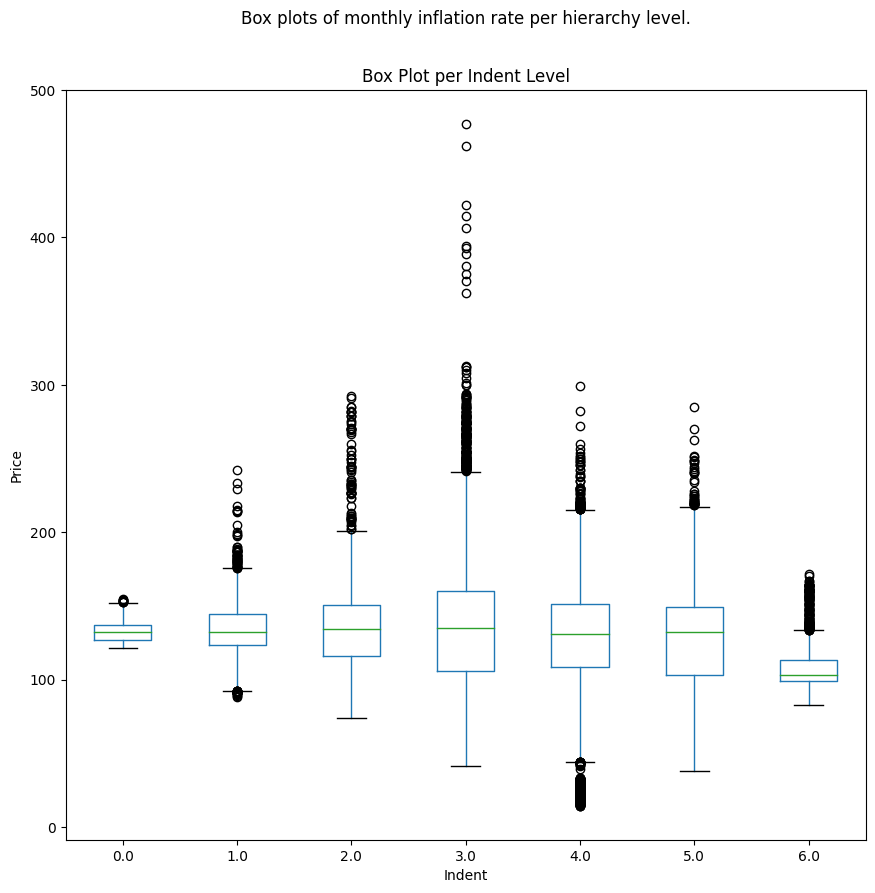

In [8]:
# Create box plots for each indent level
canada_data.boxplot(column='Price', by='Indent', grid=False, figsize=(10,10))
plt.title('Box Plot per Indent Level')
plt.xlabel('Indent')
plt.ylabel('Price')
plt.suptitle('Box plots of monthly inflation rate per hierarchy level.') 
plt.show()

--------

### Horizon Analyses:

In [9]:
# import horizon files 
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/data/hor1_test_dataset.pickle', 'rb') as f:
    canada_hor_1_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/data/hor2_test_dataset.pickle', 'rb') as f:
    canada_hor_2_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/data/hor3_test_dataset.pickle', 'rb') as f:
    canada_hor_3_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/data/hor4_test_dataset.pickle', 'rb') as f:
    canada_hor_4_test_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/data/hor8_test_dataset.pickle', 'rb') as f:
    canada_hor_8_test_dict = pickle.load(f)

In [10]:
import sys        
sys.path.append('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada')       
import model
from model.GRU_model import *
from pipeline_config import *
from model.config import * 
from model.utils import *
Lr = 0.0961278669993956

2023-09-30 21:00:44.610711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
num_forecast_steps = 8

category_horizon_dict = {}

for category_name in list(canada_hor_1_test_dict.keys()):
    # load model
    cat_model = GRUModel(input_dim=Features, hidden_dim=HiddenSize, layer_dim=LayersDim, output_dim=OutputDim, dropout_prob=DropoutProb)
    cat_optimizer = torch.optim.AdamW(cat_model.parameters(), lr=Lr)
    cat_model.to(Device)

    category_model, optimizer, checkpoint, valid_loss_min = load_checkpoint('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/mayas_project/reversed_hgru_with_corr_1 - Canada/models_weights/'+category_name+'.pt', cat_model, cat_optimizer)

    horizon_dict = {}

    # Generate forecasts step by step
    for step in range(num_forecast_steps):
        with torch.no_grad():
            # create dataloader
            x_test = canada_hor_1_test_dict[category_name].iloc[:,:-1].to_numpy()
            y_test= canada_hor_1_test_dict[category_name].iloc[:,-1:].to_numpy()

            x_test = torch.from_numpy(x_test).to(torch.float32)
            y_test = torch.from_numpy(y_test).to(torch.float32)

            test_dataset = TensorDataset(x_test, y_test)

            test_dataloader =  DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

            for inputs, labels in test_dataloader:
                # since each batch contains 32 samples, and the largest df is of size 32, then we dont need to concat the outputs per batch per category.
                inputs = inputs.view(inputs.shape[0], SequenceLength, Features)
                #print(f'inputs shape: {inputs.shape}')
                #print(f'labels shape: {labels.shape}')
                inputs, labels = inputs.to(Device), labels.to(Device)
                out = category_model(inputs)
                out_df = pd.DataFrame(out)
                
                first = canada_hor_1_test_dict[category_name].iloc[:,1:].reset_index(drop = True).copy()
                print(f'first shape: {first.shape}')
                second = out_df.reset_index(drop = True).rename(columns = {0: 'Inflation t+'+str(2+step)})
                print(f'second shape: {second.shape}')

                canada_hor_1_test_dict[category_name] = pd.concat([first, second],axis=1) #prediction

                horizon_dict[step+2] = canada_hor_1_test_dict[category_name]

    category_horizon_dict[category_name] = horizon_dict
    


first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second shape: (26, 1)
first shape: (26, 13)
second sha

In [12]:
def avg_rmse_hor(prediction_dict, actual_dict, horizon):
    mse_lst = []
    for key in list(actual_dict.keys()):
        predictions = prediction_dict[key][horizon].iloc[:,-1:].reset_index(drop = True)
        actuals = actual_dict[key].iloc[:,-1:].reset_index(drop = True)

        y_pred = predictions.values
        y_actual = actuals.values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        #print(f'y pred: {predicted_values_non_null}')
        #print(f'y actual: {observed_values_non_null}')
        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        mse_lst.append(mse)
    
    rmse_list = list(map(np.sqrt,mse_lst))
    avg_rmse = np.mean(rmse_list)
    rmse_std = np.std(rmse_list)
    
    print(f'RMSE:  {avg_rmse}')
    print(f'MSE std:  {rmse_std}')
    print(f'interval: {[avg_rmse-rmse_std, avg_rmse+rmse_std]}')

    return avg_rmse,rmse_std

In [13]:
avg_rmse_hor(category_horizon_dict, canada_hor_2_test_dict, 2)

RMSE:  2.312614817898011
MSE std:  2.1657755621122665
interval: [0.14683925578574453, 4.478390380010278]


(2.312614817898011, 2.1657755621122665)

In [14]:
avg_rmse_hor(category_horizon_dict, canada_hor_3_test_dict, 3)

RMSE:  2.4421120704736294
MSE std:  2.4724172530789033
interval: [-0.030305182605273817, 4.914529323552532]


(2.4421120704736294, 2.4724172530789033)

In [15]:
avg_rmse_hor(category_horizon_dict, canada_hor_4_test_dict, 4)

RMSE:  2.4242592220877235
MSE std:  2.417450937861943
interval: [0.006808284225780614, 4.841710159949667]


(2.4242592220877235, 2.417450937861943)

In [16]:
avg_rmse_hor(category_horizon_dict, canada_hor_8_test_dict, 8)

RMSE:  2.5167959967116342
MSE std:  2.580243155769009
interval: [-0.06344715905737486, 5.097039152480644]


(2.5167959967116342, 2.580243155769009)

In [17]:
#category_horizon_dict - prediction dict per category per horizon
# us_hor_x_test_dict - actual dict per category for horizon x

In [18]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_2_period_dataset_dict.pickle', 'rb') as f:
    hor_2_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_3_period_dataset_dict.pickle', 'rb') as f:
    hor_3_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_4_period_dataset_dict.pickle', 'rb') as f:
    hor_4_raw_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/CPI_HRNN - version 2.0/pickle files/bi_directional_canada_8_period_dataset_dict.pickle', 'rb') as f:
    hor_8_raw_dataset_dict = pickle.load(f)

In [21]:
def create_test_dataframe(raw_dataset_dict: dict, horizon:int):
    test_dict = {}
    for key in raw_dataset_dict.keys():
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Inflation t+'+str(horizon)]]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
        target_df = df[df['Year'] > 2020]
        target_df = target_df.reset_index(drop = True)
        test_dict[key] = target_df
    return test_dict

In [22]:
test_dict_hor_2 = create_test_dataframe(hor_2_raw_dataset_dict, 2)
test_dict_hor_3 = create_test_dataframe(hor_3_raw_dataset_dict, 3)
test_dict_hor_4 = create_test_dataframe(hor_4_raw_dataset_dict, 4)
test_dict_hor_8 = create_test_dataframe(hor_8_raw_dataset_dict, 8)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_3073/3431962343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_3073/3431962343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+'+str(horizon): 'Actual Horizon '+str(horizon)}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_3073/3431962343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [23]:
def get_df_with_predictions_horizon(prediction_dic: dict, actual_dic:dict, horizon: int) -> dict:
    all_data_dict = {}
    for key in list(prediction_dic.keys()):
        predictions = prediction_dic[key][horizon].iloc[:,-1:].reset_index(drop = True)
        predictions = predictions.rename(columns = {f'Inflation t+{horizon}': f'Prediction Horizon {horizon}'})
        actuals = actual_dic[key]

        data = pd.concat([predictions, actuals], axis=1).loc[:,['Category','Date','Year',f'Prediction Horizon {horizon}', f'Actual Horizon {horizon}']]
        all_data_dict[key] = data
        
    return all_data_dict

In [24]:
all_data_test_dict_hor_2 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_2,2)
all_data_test_dict_hor_3 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_3,3)
all_data_test_dict_hor_4 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_4,4)
all_data_test_dict_hor_8 = get_df_with_predictions_horizon(category_horizon_dict, test_dict_hor_8,8)

In [26]:
all_data_test_dict_hor_2['All-items']

,Category,Date,Year,Prediction Horizon 2,Actual Horizon 2
0,All-items,2021-01-15,2021.0,0.860454,0.502694
1,All-items,2021-02-15,2021.0,0.462904,0.500180
2,All-items,2021-03-15,2021.0,-0.040991,0.497690
3,All-items,2021-04-15,2021.0,0.822317,0.283286
4,All-items,2021-05-15,2021.0,0.692317,0.634475
5,All-items,2021-06-15,2021.0,0.649540,0.210600
6,All-items,2021-07-15,2021.0,0.319426,0.210158
7,All-items,2021-08-15,2021.0,0.450800,0.697353
8,All-items,2021-09-15,2021.0,0.619941,0.208261
9,All-items,2021-10-15,2021.0,0.438073,-0.138793


In [27]:
def plot_results_horizon(all_data_dict, categories, horizon):
    #category_samples = random.sample(categories, 5)+['All items']
    category_samples = categories
    for category in category_samples:
        category_df = all_data_dict[category]
        y_pred = category_df[f'Prediction Horizon {horizon}'].values
        y_actual = category_df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        mse = mean_squared_error(predicted_values_non_null, observed_values_non_null)
        print(f'Category is: {category}')
        print(f'RMSE is: {np.sqrt(mse)}')

        fig = px.line(category_df, x="Date", y=[f'Actual Horizon {horizon}', f'Prediction Horizon {horizon}'], title=f'{category} - Actual VS Prediction: horizon {horizon}')
        fig.show()



In [28]:
def total_corr_horizon(all_data_test_dict, horizon):
    corr_dict = {}
    for key in list(all_data_test_dict.keys()):
        df = all_data_test_dict[key]
        y_pred = df[f'Prediction Horizon {horizon}'].values
        y_actual = df[f'Actual Horizon {horizon}'].values

        non_null_indices = ~np.isnan(y_pred) & ~np.isnan(y_actual)

        predicted_values_non_null = y_pred[non_null_indices]
        observed_values_non_null = y_actual[non_null_indices]

        corr = stats.pearsonr(predicted_values_non_null,observed_values_non_null)[0]
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    print(f'Total Corr Horizon {horizon}, {total_corr}')
    return total_corr

In [29]:
total_corr_horizon(all_data_test_dict_hor_2, 2)
total_corr_horizon(all_data_test_dict_hor_3, 3)
total_corr_horizon(all_data_test_dict_hor_4, 4)
total_corr_horizon(all_data_test_dict_hor_8, 8)

Number of categories with High Correlation: 8
Total Corr Horizon 2, -6.863501717260072
Number of categories with High Correlation: 9
Total Corr Horizon 3, -4.050725529108256
Number of categories with High Correlation: 3
Total Corr Horizon 4, -6.0407061538664895
Number of categories with High Correlation: 5
Total Corr Horizon 8, -5.001992302304317


-5.001992302304317

In [30]:
cats = list(all_data_test_dict_hor_2.keys())
categories = random.sample(cats, 5)+['All-items']

In [31]:
#categories = list(all_data_test_dict_hor_2.keys())
plot_results_horizon(all_data_test_dict_hor_2, categories, 2)

Category is: Household appliances
RMSE is: 1.7469395386577502


Category is: Upholstered furniture
RMSE is: 2.5578540970533794


Category is: Digital computing equipment and devices
RMSE is: 2.632120932051177


Category is: Other lessons, courses and education services
RMSE is: 1.1769519448739352


Category is: Recreational services
RMSE is: 0.8537121322875149


Category is: All-items
RMSE is: 0.46767609678838756


In [32]:
#categories = list(all_data_test_dict_hor_3.keys())
plot_results_horizon(all_data_test_dict_hor_3, categories, 3)

Category is: Household appliances
RMSE is: 2.2326263823389727


Category is: Upholstered furniture
RMSE is: 2.7184008544126605


Category is: Digital computing equipment and devices
RMSE is: 2.3892583006074846


Category is: Other lessons, courses and education services
RMSE is: 1.2684177849266158


Category is: Recreational services
RMSE is: 0.8900791171281649


Category is: All-items
RMSE is: 0.5339124926834917


In [33]:
#categories = list(all_data_test_dict_hor_4.keys())
plot_results_horizon(all_data_test_dict_hor_4, categories, 4)

Category is: Household appliances
RMSE is: 1.9912849008035114


Category is: Upholstered furniture
RMSE is: 2.5987010333437595


Category is: Digital computing equipment and devices
RMSE is: 2.6175868126546087


Category is: Other lessons, courses and education services
RMSE is: 1.0752058013915573


Category is: Recreational services
RMSE is: 0.8910896186692023


Category is: All-items
RMSE is: 0.5531747930363989


In [34]:
#categories = list(all_data_test_dict_hor_8.keys())
plot_results_horizon(all_data_test_dict_hor_8, categories, 8)

Category is: Household appliances
RMSE is: 1.5724161434627821


Category is: Upholstered furniture
RMSE is: 2.736603377498777


Category is: Digital computing equipment and devices
RMSE is: 2.845884792817094


Category is: Other lessons, courses and education services
RMSE is: 1.1883347916178213


Category is: Recreational services
RMSE is: 0.5671801000240266


Category is: All-items
RMSE is: 0.5399970690882313
